<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/field_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pysheds
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 44.2 MB/s eta 0:00:00


In [2]:
from pysheds.grid import Grid
import rasterio as rio
import geopandas as gpd
import pandas as pd
from google.colab import drive
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import colors

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
grid = Grid.from_raster('/content/drive/MyDrive/field_data/output_USGS1m.tif')
dem = grid.read_raster('/content/drive/MyDrive/field_data/output_USGS1m.tif')

In [5]:
filled_dem = grid.fill_pits(dem)
flooded_dem = grid.fill_depressions(filled_dem)
inflated_dem = grid.resolve_flats(flooded_dem)
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

In [6]:
acc = grid.accumulation(fdir, dirmap=dirmap)

In [13]:
# ppx, ppy = 545500.29, 4124532.88
ppx, ppy = 545545.0, 4124458.0

x_snap, y_snap = grid.snap_to_mask(acc > 100000, (ppx, ppy))

catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')

# grid.clip_to(catch)

clipped_catch = grid.view(catch)

In [51]:
lines = grid.extract_river_network(fdir, acc>8000, dirmap=dirmap)

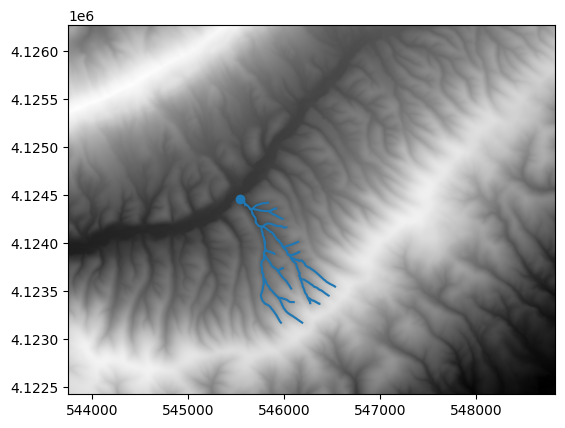

In [59]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
im = ax.imshow(dem, extent=grid.extent, zorder=2, norm=colors.LogNorm(dem.min(), dem.max()), interpolation='bilinear', cmap='Greys_r')
# c = ax.imshow(np.where(catch, catch, np.nan), extent=grid.extent, zorder=3, alpha=0.7, cmap='Greys')
for l in lines['features']:
    reach = np.asarray(l['geometry']['coordinates'])
    ax.plot(reach[:, 0], reach[:, 1], c='tab:blue')
ax.scatter(ppx, ppy, zorder=5)

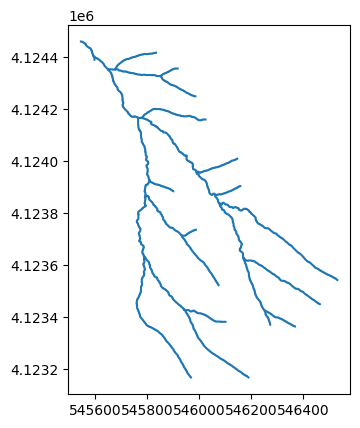

In [53]:
fig, ax1 = plt.subplots()
for l in lines['features']:
    reach = np.asarray(l['geometry']['coordinates'])
    ax1.plot(reach[:, 0], reach[:, 1], c='tab:blue')
    ax1.set_aspect('equal')

TypeError: unhashable type: 'Feature'